# Tutorial: A beginner's guide to the Probabilistic Generative Models package using the `MTCOV` algorithm 

This tutorial demonstrates the application of the _Probabilistic Generative Models_ (`pgm`) package by executing the `MTCOV` algorithm on a sample dataset.  

The `MTCOV` algorithm, an acronym for **M**ulti**t**ensor and **Cov**ariates, is a probabilistic generative model. It is specifically designed to perform community detection and broader inference in attributed multilayer networks. These networks are characterized by their enrichment with node and edge metadata.

## Package Structure
Before explaining how to use the `MTCOV` algorithm, let's explore the structure of the `pgm` 
package, which is organized into four main modules.

### 1. Input
The `input` module handles data input for subsequent use by the algorithms in the `model` module. It comprises the following submodules:  

- `loader`: Functions to load data from input files.  
- `preprocessing`: Functions for data preprocessing, such as converting NetworkX graphs to sparse adjacency matrices.  
- `tools`: Utility functions for working with matrices, tensors, and sparsity.  
- `stats`: Functions for computing statistics on the data.  
- `generate_networks`: Functions for generating synthetic networks.  

In most cases where users have their own data, they typically use only the `loader` and `preprocessing` modules. The other modules serve as internal components supporting these primary functionalities. The `generate_networks` is instead utilized to generate synthetic networks.

### 2. Model
The `model` module encompasses the implementation of various algorithms, including the following submodules:  

- `MTCOV`: Implementation of the `MTCOV` algorithm.
- `CRep`: Implementation of the `CRep` algorithm.  
- `JointCRep`: Implementation of the `JointCRep` algorithm. 
- `cv_CRep`: Cross-validation for the CRep algorithm.
- `cv`: Implementation of the general cross-validation routine.  


### 3. Output
The `output` module contains functions responsible for handling the outputs of the models. It consists of the following submodules:

- `evaluate`: Essential functions for computing quantities related to the model and its assessment, such as conditional and marginal expectations, the data log-likelihood, and the AUC for link prediction. 
- `plot`: Functions for visualizing the results and performance metrics of the models.

### 4. Data
The `data` module contains the data files used by the package. It consists of the following submodules:

- `input`: Input data files.
- `model`: Configuration files for the models.

Having explored the package structure, let's see how to use it to run the `MTCOV` algorithm.

## Configuration
Let's start by configuring the algorithm and the parameters needed. The pipeline works based on two types of parameters:

**Numerical Parameters:** These are operational parameters that control the execution of the algorithm. They are not directly related to the model's theoretical framework but are crucial for its practical implementation. Examples include:

- **Convergence tolerance (convergence_tol):** This is a threshold used to determine when the algorithm has converged, i.e., when the changes in the model's likelihood or parameters between iterations are small enough to consider the model as having reached its final state.

- **Maximum number of iterations (max_iter):** This is the maximum number of times the algorithm will update the model's parameters. If the model hasn't converged by this point, the algorithm will stop anyway.

- **Number of realizations (num_realizations):** In the context of the `MTCOV` algorithm, this refers to the number of times the entire process (initialization and iterative updates) is repeated. The algorithm will then return the best realization, that is, for instance, the one with the highest likelihood upon convergence. This is done to account for the randomness in the initialization step and to ensure a more robust final model. 

These are set by default in the model's class definition, but they can be changed by the user.

**Model parameters:**  These are parameters that are part of the model's theoretical framework. They have a direct impact on the model's behavior and the results it produces. Examples include:

- **Number of communities (K)**: This is a fundamental parameter of the `MTCOV` algorithm. It determines the number of communities the algorithm will try to find in the network. Each node in the network will be assigned to one of these communities, at least.

- **Scaling parameter (gamma)**: This is another fundamental parameter of the `MTCOV` algorithm. 
It controls the relative contribution of the two terms in the likelihood, which accounts for network topology and node covariates, respectively. When `gamma=0`, the inference is performed by analyzing the data purely in terms of the network topology. Vice versa, when `gamma=1`, the algorithm only uses the attribute information.

These are set by the user in the configuration file corresponding to the used model. In the case of the `MTCOV` algorithm, this file is `setting_MTCOV.yaml`.  

Notice that the data is not a parameter, but an input to the algorithm, hence, it is not included in the default configuration of the class nor in the configuration file. This will be shown later in the tutorial.

As a first step, let's configure the logger to show the information about the execution of the algorithm.

In [1]:
# Import the logging module
import logging

# Get the root logger and set its level to INFO
logging.getLogger().setLevel(logging.INFO)

In [2]:
from pathlib import Path

import numpy as np
import yaml

Let's start by loading the configuration file for the `MTCOV` algorithm. This file is located in 
the `pgm/data/model` folder. 

In [3]:
# Set the algorithm to 'MTCOV'
algorithm = "MTCOV"

# Define the path to the configuration file for the `MTCOV` algorithm
config_path = "setting_" + algorithm + ".yaml"

We load the configuration file using the data files in the `pgm` package instead of a relative path to it.

In [4]:
# Import the `open_binary` function from the `importlib.resources` module
# This function is used to open a binary file included in a package
from importlib.resources import open_binary

# Open the configuration file for the `MTCOV` algorithm
# The `open_binary` function takes two arguments:
# - The name of the package where the file is located (`pgm.data.model`)
# - The name of the file to open (`config_path`)
# The function returns a binary file object, which is opened in read mode
with open_binary("pgm.data.model", config_path) as fp:
    # Load the content of the configuration file into a dictionary
    # The `load` function from the `yaml` module is used to
    # convert the data from a YAML formatted string into a Python dictionary.
    # The `Loader=yaml.Loader` argument specifies the loader class to use for
    # loading the data.
    conf = yaml.load(fp, Loader=yaml.Loader)

In [5]:
# Print the configuration file
print(yaml.dump(conf))

K: 2
assortative: false
end_file: _MTCOV
files: ../data/input/theta.npz
gamma: 0.5
initialization: 0
out_folder: outputs/
out_inference: true
rseed: 107261



The previous file shows the parameters actually needed to _run_ the model. These parameters set the algorithm basic needs to work.  

 

Now, let's change the path to the output folder, so we can save the results into the same folder where this notebook is. 

In [82]:
# Set the output folder for the `MTCOV` algorithm
# The output folder is set to the current directory, with
# the folder name being the algorithm name followed by '_output/'
conf["out_folder"] = "./tutorial_outputs/" + algorithm

# Set the end file for the `MTCOV` algorithm
# The end file is set to be '_' followed by the algorithm name
conf["end_file"] = "_" + algorithm

In [83]:
# Define the output folder
out_folder = Path(conf["out_folder"])

# Ensure the output folder exists
out_folder.mkdir(parents=True, exist_ok=True)

Finally, let's save this configuration file to the output folder, so we can keep track of the parameters used to run the model.

In [84]:
# Define the path for the output configuration file
# The output configuration file is located in the output folder for
# the `MTCOV` algorithm.
# The file name is 'setting_' followed by the algorithm name with
# a '.yaml' extension.
output_config_path = conf["out_folder"] + "/setting_" + algorithm + ".yaml"

# Open the output configuration file in write mode
with open(output_config_path, "w") as f:
    # Write the contents of the `conf` dictionary to the file
    # The `dump` function from the `yaml` module is used to convert
    # the data from a Python dictionary into a YAML formatted string.
    # The `f` argument specifies the file object where the
    # data should be written.
    yaml.dump(conf, f)

## Importing Data
Once the configuration file is set, we can import the data. 
Now, let's import the data using the `pgm` package.

In [96]:
from pgm.input.loader import import_data_mtcov

# Define the names of the columns in the input file that
# represent the source and target nodes of each edge.
ego = "source"
alter = "target"
egoX = "Name"

# Set the `force_dense` flag to False
# This flag determines whether the adjacency matrices
# should be stored as dense matrices.
# If set to False, the adjacency matrices will be stored
# as sparse matrices, which is more memory-efficient
# for large networks with few edges.
force_dense = False

# Get the absolute path of the root directory of the project
root_dir = Path.cwd().parent.parent.parent.resolve()

# Define the path to the input folder
in_folder = str(root_dir / "pgm/data/input/")

# Define the name of the network file
adj_name = "adj.csv"

# Define the name of the covariates file
cov_name = "X.csv"

# Define the attribute name
attr_name = "Metadata"

# Flag to treat the network as undirected
undirected = False

# Call the `import_data_mtcov` function to load the data from the input file
# The function takes several arguments:
# - in_folder: the path to the data
# - adj_name: the name of the file with the adjacency matrix
# - cov_name: the name of the file with the design matrix
# - ego: the name of the column that references the node in one extreme of the directed edge
# - alter: the name of the column that references the other node
# - attr_name: name of the attribute to consider in the analysis
# - undirected: the flag that signals if the network is undirected
# - force_dense: if set to True, the algorithm is forced to consider a dense adjacency tensor
# - noselfloop : if set to True, the algorithm removes the self-loops

A, B, X, nodes = import_data_mtcov(
    in_folder,
    adj_name=adj_name,
    cov_name=cov_name,
    ego=ego,
    alter=alter,
    egoX=egoX,
    attr_name=attr_name,
    undirected=undirected,
    force_dense=force_dense,
    noselfloop=True,
)

INFO:root:Number of nodes = 300
INFO:root:Number of layers = 4


The previous call to `import_data_mtcov` loads the data from the input folder, and returns the 
following:

- `A`: A list of MultiGraph (or MultiDiGraph if `undirected=False`) NetworkX objects
- `B`: The adjacency tensor describing the graphs in `A`
- `X`: A pandas DataFrame object representing the one-hot encoding version of the design matrix
- `nodes`: A list of the nodes in the graph
    

To get some information about the data, we can call the `print_graph_stat` function from the `input.stats` module.

In [86]:
from pgm.input.stats import print_graph_stat

# Call the `print_graph_stat` function to print the basic
# statistics of the graphs in the list `A`.
# The function takes one argument:
# - A list of NetworkX graphs ('A')
print_graph_stat(A)

INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 1294 - <k> = 8.627
INFO:root:Sparsity [0] = 0.014
INFO:root:Reciprocity (networkX) = 0.028
INFO:root:E[1] = 1340 - <k> = 8.933
INFO:root:Sparsity [1] = 0.015
INFO:root:Reciprocity (networkX) = 0.021
INFO:root:E[2] = 724 - <k> = 4.827
INFO:root:Sparsity [2] = 0.008
INFO:root:Reciprocity (networkX) = 0.03
INFO:root:E[3] = 742 - <k> = 4.947
INFO:root:Sparsity [3] = 0.008
INFO:root:Reciprocity (networkX) = 0.003


Let's now show the adjacency matrix of one of the four layers.

In [87]:
import networkx as nx

# Get the first graph
graph = A[0]

# Get the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(graph)

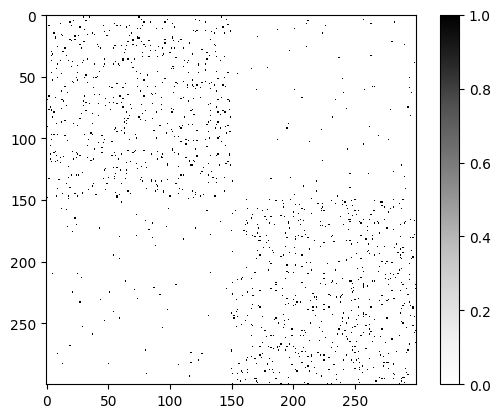

In [88]:
# Import the `pyplot` module from `matplotlib` for creating
# static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt

# Display the reshaped adjacency matrix `B_reshaped` as an image
# The `imshow` function from the `pyplot` module is used to
# display data as an image.
# The `cmap` argument specifies the colormap to use for the image
# The `interpolation` argument specifies the interpolation method
# to use when resizing the image.
plt.imshow(adjacency_matrix.toarray(), cmap="Greys", interpolation="none")

# Add a color bar to the plot for reference
# The colors in the color bar correspond to the values in the image:
# black for 1, meaning a connection, and white for 0, meaning no connection.
plt.colorbar()

As we can see in the matrix, the network is not fully connected, i.e., there are nodes that are not 
connected to any other node. This is a common characteristic of real-world networks. More 
importantly, we can see that the network has two main clusters of nodes, which are represented by the two regions more densely connected. These are the communities that the `MTCOV` algorithm will try to detect.

## Running the Model
Finally, we are ready to run the `MTCOV` model! The way this works is in a two-step process: <br>
i) first, we call the `MTCOV` class, which initializes the model; <br>
ii) then, we call the `fit` method, which runs the algorithm. 

In [89]:
# Import the `MTCOV` class from the `pgm.model.mtcov` module
# This class is used to create an instance of the `MTCOV` algorithm
from pgm.model.mtcov import MTCOV

# Import the `time` module
# This module provides various time-related functions
import time

# Create an instance of the `MTCOV` class
# The `MTCOV` class takes no arguments, unless the user wants
# to change the default of the numerical parameters.
model = MTCOV()

# Print all the attributes of the `MTCOV` instance
# The `__dict__` attribute of an object is a dictionary containing
# the object's attributes.
# These correspond to the numerical parameters
print(model.__dict__)

{'inf': 10000000000.0, 'err_max': 1e-07, 'err': 0.1, 'num_realizations': 1, 'convergence_tol': 0.0001, 'decision': 10, 'max_iter': 500, 'plot_loglik': False, 'flag_conv': 'log'}


Model created! Now, we can run the model using the `fit` method. As mentioned before, this method takes as input the data, and the configuration parameters.

In [90]:
# Print a message indicating the start of the `MTCOV` algorithm
print(f"\n### Run {algorithm} ###")

# Get the current time
time_start = time.time()

# Run the `MTCOV` model
# The `fit` method of the `MTCOV` class takes several arguments:
# - data: The adjacency tensor
# - data_X: The covariate matrix
# - nodes: The list of nodes in the graph

_ = model.fit(data=B, data_X=np.array(X), nodes=nodes, **conf)

# Print the time elapsed since the start of the `MTCOV` algorithm
print(f"\nTime elapsed: {np.round(time.time() - time_start, 2)} seconds.")


### Run MTCov ###


INFO:root:Inferred parameters saved in: /home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/doc/source/tutorials/tutorial_outputs/MTCov/theta_MTCov.npz
INFO:root:To load: theta=np.load(filename), then e.g. theta["u"]



Time elapsed: 2.23 seconds.


Done! The final state of the model is not returned, but it is saved to the output folder.

## Analyzing the results
Next, we will examine the outcomes produced by the model. To do this, it is necessary to load the
 contents from the file `MTCOV_output/theta_MTCOV.npz.`

In [91]:
# Define the path to the file containing the results of the `MTCOV` model
# The file is located in the 'MTCOV_output' folder and has a '.npz' extension
filename = conf["out_folder"] + "/theta_" + algorithm + ".npz"

# Load the contents of the file into a dictionary
theta = np.load(filename)

Once this is done, we can unpack the latent variables.

In [92]:
# Unpack the latent variables from the results of the `MTCOV` model
# The `u` variable represents the out-going memberships of the
# nodes in the graph.
# The `v` variable represents the in-coming memberships of the
# nodes in the graph.
# The `w` variable represents the affinity of the communities
# for each layer.
# The `beta` variable represents the relationships between
# communities and covariates.
u, v, w, beta = theta["u"], theta["v"], theta["w"], theta["beta"]

As outlined in [1], `MTCOV` assumes a mixed-membership community structure, which means that 
every node can belong to more than one community with a different strength. The variables `u` and `v` are $N\times K$ membership matrices that represent the out-going and in-coming node memberships, respectively. In this specific demonstration, it's important to recall that we configured the model parameter `K`, representing the number of communities, to be $2$. Consequently, by examining the values of `u` for each node, we expect to obtain vector of length two, where the first entry is the probability of node $i$ to belong to community $1$ and the second one represents the probability to belong to community $2$.

In [93]:
# Iterate over the first 10 nodes in the graph
for idx, values in enumerate(u[:10]):
    # Print the probability that the node belongs to the two communities
    print(
        f"The probability that the node {idx} belongs to the two communities is: {values}"
    )

The probability that the node 0 belongs to the two communities is: [0.00163062 0.99836938]
The probability that the node 1 belongs to the two communities is: [0. 1.]
The probability that the node 2 belongs to the two communities is: [0. 1.]
The probability that the node 3 belongs to the two communities is: [0. 1.]
The probability that the node 4 belongs to the two communities is: [0. 1.]
The probability that the node 5 belongs to the two communities is: [0.06063502 0.93936498]
The probability that the node 6 belongs to the two communities is: [0. 1.]
The probability that the node 7 belongs to the two communities is: [0. 1.]
The probability that the node 8 belongs to the two communities is: [0.06281463 0.93718537]
The probability that the node 9 belongs to the two communities is: [0. 1.]


To visualize the hard-membership for the out-going case, we can assign each node to the community with the highest probability in `u`. We can then print the community assignments for the first $10$ nodes.

In [94]:
# Calculate the hard-membership for the out-going case
u_hard = np.argmax(u, axis=1)

# Get the indices of nodes in community 1 and community 2
community1_nodes = np.where(u_hard == 0)[0]  # Community 1 corresponds to index 0
community2_nodes = np.where(u_hard == 1)[0]  # Community 2 corresponds to index 1

# Print some nodes from community 1
print("Some nodes in community 1:")
print(community1_nodes[:10])

# Print some nodes from community 2
print("\nSome nodes in community 2:")
print(community2_nodes[0:10])

Some nodes in community 1:
[150 151 152 153 154 155 156 157 158 159]

Some nodes in community 2:
[0 1 2 3 4 5 6 7 8 9]


We have learned this way to assign each node to a community, using the results given by the 
`MTCOV` algorithm. For a more graphical approach, we invite the reader to see the tutorial on the 
[`JointCRep` algorithm](./JointCRep.ipynb), where we show how to plot the communities in the 
network.

In addition to investigate the node memberships, we can interpret the relationships between the inferred communities and the node covariate through the variable `beta`. As outlined in [1], `beta` is a $K\times Z$ dimensional matrix, where $Z$ denotes the total number of different categories of the node attribute. In this example, the attribute Metadata has $2$ categories. Then, every row $k$ of the beta matrix denotes how much information of the different categories is used to create the $k$-th community. Also, this variable is normalized such that every row sums to $1$.

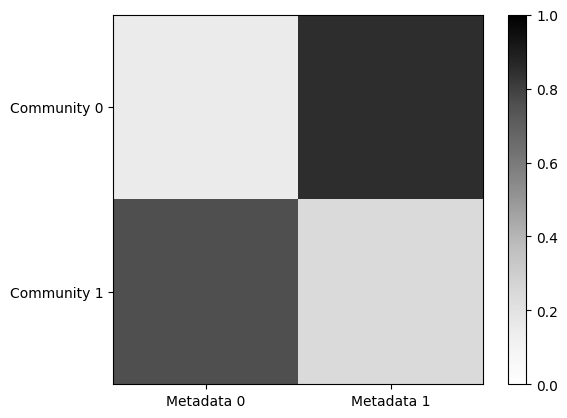

In [95]:
plt.imshow(beta, cmap="Greys", interpolation="none", vmin=0, vmax=1)

plt.xticks([0, 1], ["Metadata 0", "Metadata 1"])
plt.yticks([0, 1], ["Community 0", "Community 1"])

plt.colorbar()

Through this plot, we can infer that community $0$ is mainly related to nodes with Metadata $0$, while community $1$ groups together primarily nodes with attribute Metadata $1$.

For more details about the meaning of the latent variables, we refer the user to the publication [1]. And, for a tutorial on how to generate networks that follow a particular probabilistic model, 
please check the notebook [`CRep` algorithm](./CRep.ipynb).

## Summary

This tutorial provides a comprehensive guide on using the Probabilistic Generative Models (`pgm`) package, specifically focusing on the `MTCOV` algorithm. The `MTCOV` 
algorithm is a probabilistic generative model used for network analysis, designed to detect 
communities within a multilayer network where node attributes are considered.

The tutorial begins by explaining the structure of the `pgm` package, which is organized into four main modules: `input`, `model`, `output`, and `data`. Each module has its own submodules and functionalities.

The tutorial then proceeds to demonstrate how to configure the `MTCOV` algorithm using a YAML 
configuration file. It shows how to load the configuration file, modify the output folder path, and save the updated configuration.

Next, the tutorial guides the user on how to import data using the `pgm` package. It demonstrates how to load data from an input file and print basic statistics of the loaded data. It also shows how to visualize the adjacency matrix of the network.

The tutorial then explains how to run the `MTCOV` model. It demonstrates how to create an 
instance of the `MTCOV` class and run the model using the `fit` method.

Finally, the tutorial shows how to analyze the results produced by the model. It explains how to load the results from a file, unpack the latent variables, and calculate the hard membership for the out-going case. It also shows how to interpret the relationships between communities and attribute categories. It concludes by referring the user to other tutorials for additional visualizations and functionalities, and to the publication where `MTCOV` was presented for more details about the meaning of the latent variables.

## References

[1] Contisciani, M., Power, E. A., & De Bacco, C. (2020). Community detection with node 
attributes in multilayer networks. _Scientific reports_, 10(1), 15736.